# Capstone 1: Liver Disease Prediction
## Data Exploration/Storytelling

### Nils Madsen

___

### Questions:


1. Which variables appear to be important for the prediction of liver disease? How do the distributions of the diagnostic metrics compare between liver patients and controls?

2. What are the relationships between the variables? Are all liver tests that appear related to liver disease correlated with one another?
___

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
#load cleaned data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())
liver_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None


,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,True
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,True
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,True
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,True
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,True


___
### Question 1

Which variables appear to be important for the prediction of liver disease? How do the distributions of the diagnostic metrics compare between liver patients and controls?

In [4]:
# split dataset into controls and liver patients
disease_df = liver_df[liver_df['liver disease'] == True]
control_df = liver_df[liver_df['liver disease'] == False]

# initialize results df
numeric_metrics = ['age', 'total bili', 'direct bili', 'ALP', 'ALT', 'AST', 'total protein', 'albumin', 'a-g ratio']

ttest_results = pd.DataFrame(numeric_metrics)
ttest_results.set_index(0, inplace=True)
ttest_results.index.name = 'diagnostic metric'

# run t-tests
for metric in numeric_metrics:
    t, p = stats.ttest_ind(disease_df[metric], control_df[metric])
    ttest_results.loc[metric, 'liver patient mean'] = disease_df[metric].mean()
    ttest_results.loc[metric, 'control mean'] = control_df[metric].mean()
    ttest_results.loc[metric, 't-statistic'] = t
    ttest_results.loc[metric, 'p-value'] = p

ttest_results

,liver patient mean,control mean,t-statistic,p-value
diagnostic metric,,,,
age,46.153846,41.239521,3.342369,8.840632e-04
total bili,4.164423,1.142515,5.441441,7.801431e-08
direct bili,1.923558,0.396407,6.118790,1.734103e-09
ALP,319.007212,219.754491,4.534141,7.027487e-06
ALT,99.605769,33.652695,3.992646,7.371781e-05
AST,137.699519,40.688623,3.705217,2.313901e-04
total protein,6.459135,6.543114,-0.844354,3.988191e-01
albumin,3.060577,3.344311,-3.941755,9.074361e-05
a-g ratio,0.914337,1.028588,-3.965115,8.251144e-05


All numeric metrics, with the exception of total protein, are significantly different in the disease and control groups. Age, bilirubin, ALP, ALT, and AST are all higher in the disease group, while albumin and a-g ratio are lower in the disease group. Since these tests are used to diagnose liver disease, it makes sense that they would be associated with a liver disease diagnosis in a statistically-significant way. 

Total protein is the exception here, and the fact that it is not significantly associated with a liver disease diagnosis raises questions about its utility here. When the machine learning model is trained, it may be worthwhile to investigate the model's performance with and without this feature included.

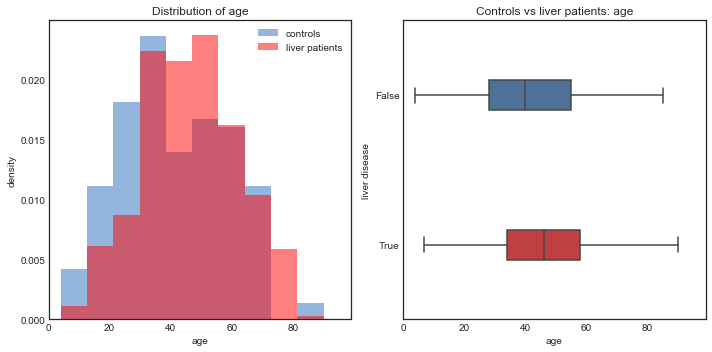

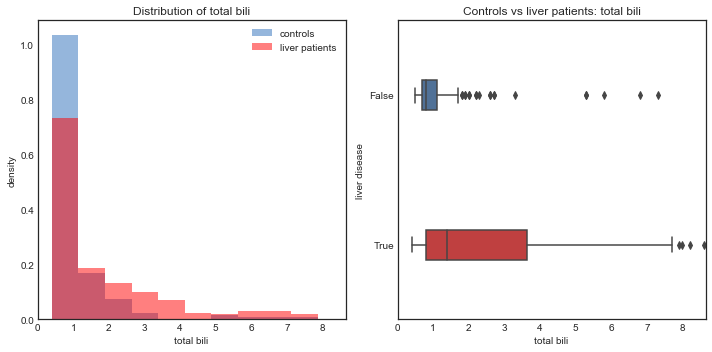

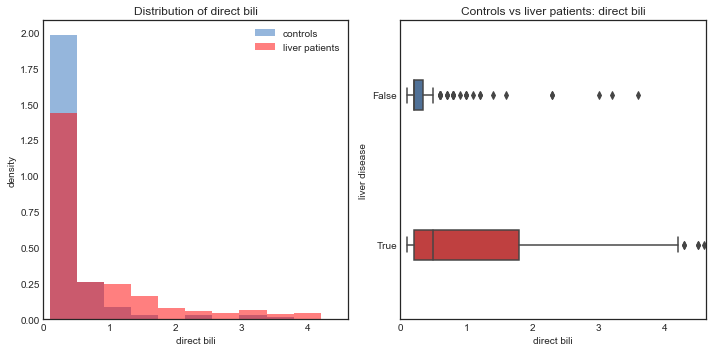

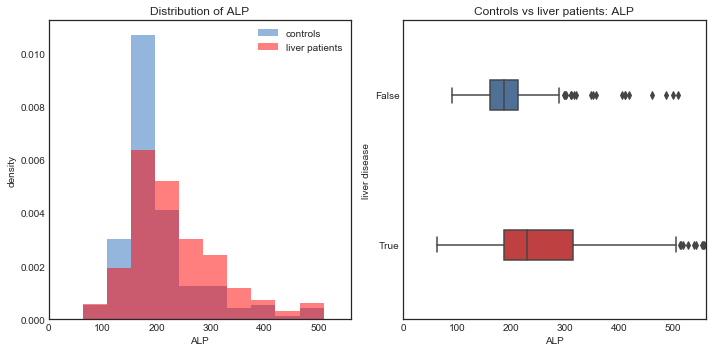

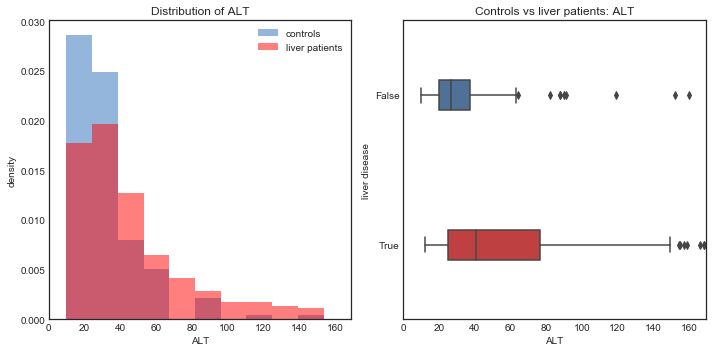

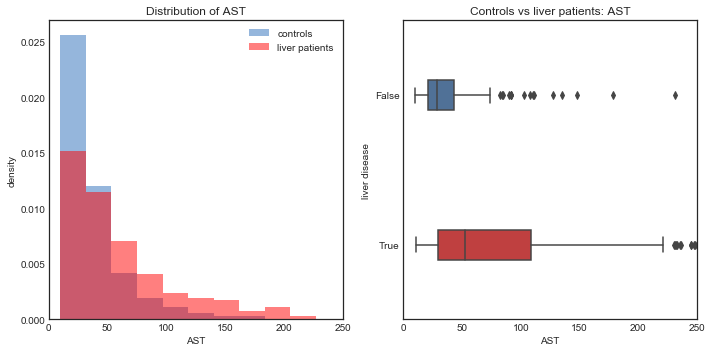

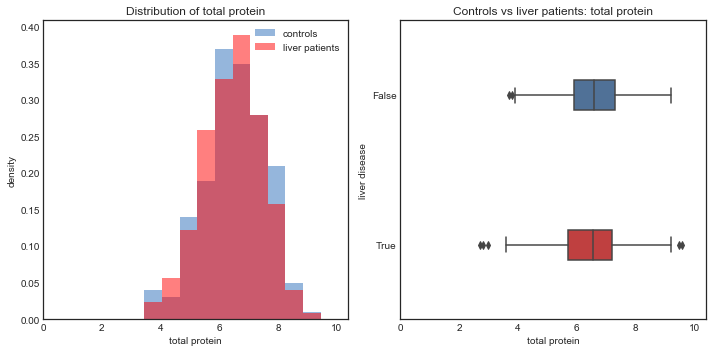

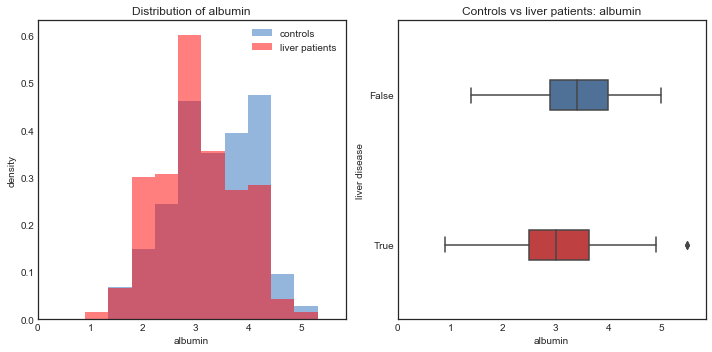

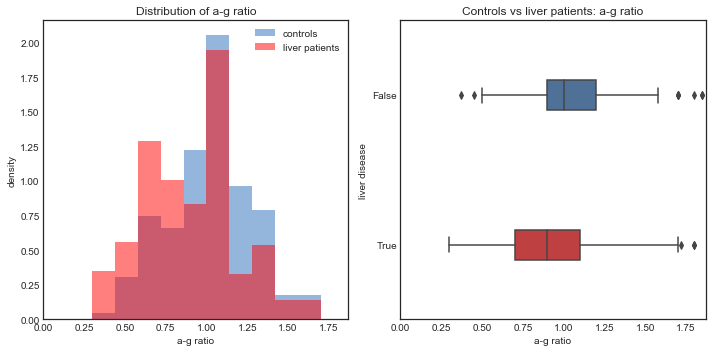

In [12]:
# plot distributions of diagnostic measures in controls and liver patients
sns.set_style('white')

def hist_overlay(df, field):
    ''' Plots an overlay histogram of controls and liver disease patients for comparison, as well as boxplot '''
    
    # split data into controls and liver patients
    disease_df = liver_df[liver_df['liver disease'] == True]
    control_df = liver_df[liver_df['liver disease'] == False]
    
    # find whisker limits for boxplot
    control_iqr = control_df[field].quantile([0.25, 0.75])
    control_iqr_span = np.ptp(control_iqr)
    control_min = max(min(control_iqr) - 1.5*control_iqr_span, min(control_df[field]))
    control_max = min(max(control_iqr) + 1.5*control_iqr_span, max(control_df[field]))
    
    disease_iqr = disease_df[field].quantile([0.25, 0.75])
    disease_iqr_span = np.ptp(disease_iqr)
    disease_min = max(min(disease_iqr) - 1.5*disease_iqr_span, min(disease_df[field]))
    disease_max = min(max(disease_iqr) + 1.5*disease_iqr_span, max(disease_df[field]))
    
    x_min = min(control_min, disease_min)
    x_max = max(control_max, disease_max)
    
    n_bins = np.linspace(x_min, x_max, num=11)
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    # plot overlay histogram
    plt.subplot(1, 2, 1)
    plt.hist(control_df[field], bins=n_bins, color=sns.xkcd_rgb['medium blue'], alpha=0.5, density=True, 
             label='controls')
    plt.hist(disease_df[field], bins=n_bins, color='red', alpha=0.5, density=True, 
             label='liver patients')
    plt.title('Distribution of {}'.format(field))
    plt.xlabel('{}'.format(field))
    plt.ylabel('density')
    plt.xlim(0, x_max * 1.1)
    plt.legend(loc='upper right')
    
    # plot boxplot
    plt.subplot(1, 2, 2)
    ax = sns.boxplot(y='liver disease', x=field, data=df, palette=[sns.xkcd_rgb['medium blue'], 'red'],
                saturation=0.5, width=0.2, orient='h')
    plt.title('Controls vs liver patients: {}'.format(field))
    plt.xlim(0, x_max * 1.1)
    plt.tight_layout()
    plt.show()

# create figure for all 
for metric in numeric_metrics:
    hist_overlay(liver_df, metric)

As expected, the distributions of controls and liver patients appear to differ on all measures with the exception of total protein. The distribution of liver patients is skewed upwards in the case of age, total bilirubin, direct bilirubin, ALP, ALT and AST. The distribution of liver patients is skewed downwards in the case of albumin and a-g ratio.

### Sensitivity and specificity of blood tests

One notable observation from close inspection of the distributions above is that in many cases liver disease patients have blood tests that are normal or close to normal. This indicates that these blood tests have low sensitivity. In other words, a normal result for these blood tests cannot rule out the presence of liver disease. 

On the other hand, it appears that some of the blood tests have good specificity, or in other words a blood test result above a certain value virtually guarantees the presence of liver disease. These two conclusions, taken together, suggest that a machine learning algorithm trained on this data will be capable of high specificity but not high sensitivity.

The high specificity and low sensitivity raise an issue with the originally-proposed utility of this machine learning model; if the model cannot rule out liver disease, then it will be unable to give relevant input to a decision of whether or not to perform a liver biopsy on a patient. In cases where the model is confident that a patient has liver disease, a liver biopsy will still be required in order to diagnose the specific type of disease. In all other cases the model will be unable to make a strong prediction, and a liver biopsy will be required to rule out liver disease.

However, a model with high specificity and low sensitivity can still be valuable, because its use as a 'rule-in' test for liver disease could save some patients from undergoing unnecessary tests for other diseases in their doctor's differential diagnosis. In the context of a suite of machine-learning algorithms for different potential diagnoses, both 'rule-in' and 'rule-out' tests would be useful.

___
### Question 2

What are the relationships between the variables? Are all metrics that appear related to liver disease correlated with one another?

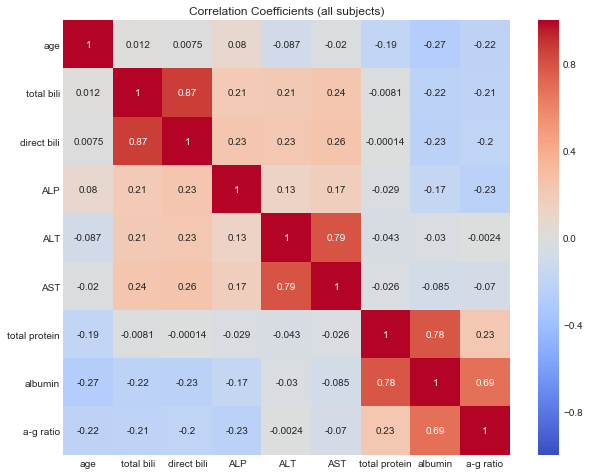

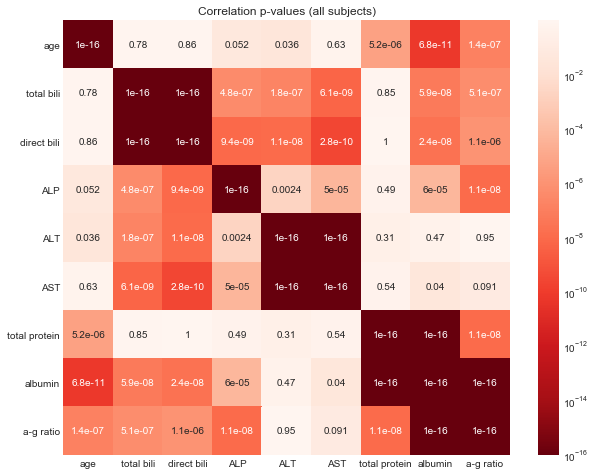

In [6]:
# visualize correlation matrix and p-values matrix
from matplotlib.colors import LogNorm

def corr_heatmaps(dataframe, figsize=(10, 8), sub_str = 'all subjects'):
    ''' displays heatmaps of correlation coefficients and the corresponding p-values '''
    
    def r_to_p(r, n=len(numeric_df.age), tails=2):
        ''' derive p-value of a Pearson correlation coefficient '''
        if r == 1:
            return 0

        t = r / ((1 - r**2)/(n - 2))**0.5
        p = tails * (1 - stats.t.cdf(abs(t), n-2))
        return p
    
    # correlation matrix heatmap
    corr = dataframe.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, center=0, cmap='coolwarm', annot=True, 
                vmin=-1, vmax=1)
    plt.title('Correlation Coefficients ({})'.format(sub_str))
    plt.savefig('correlation_matrix.png')
    plt.show()

    # generate log-scaled p-values matrix heatmap
    corr_p = corr.applymap(r_to_p)
    min_p = corr_p.min()
    corr_p = corr_p.applymap(lambda p: 1e-16 if p==0 else p) #log scale will not work with entries of 0
    plt.figure(figsize=figsize)
    sns.heatmap(corr_p, xticklabels=corr.columns, yticklabels=corr.columns, cmap='Reds_r', annot=True,
                norm=LogNorm(vmin=corr_p.min(), vmax=corr_p.max()), 
                cbar_kws={'ticks':[1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16]})
    plt.title('Correlation p-values ({})'.format(sub_str))
    plt.show()

# correlation matrix for all subjects
numeric_df = liver_df[numeric_metrics].copy()
corr_heatmaps(numeric_df)

___
There appear to be two groupings of positive correlation among the diagnostic metrics. The first group includes the liver enzymes (ALT, AST, ALP) and the two measures of bilirubin. The second group includes the blood protein measures (total protein, albumin, and a-g ratio). Within each group, all correlations are statistically significant at p < 0.01. Between the two groups, the correlations are negative or not significant.

These relationships are not surprising, given the findings above that mean bilirubin, ALT, AST, and ALP are higher in liver patients than controls, while mean albumin and a-g ratio are lower in liver patients than controls. Thus, these correlations may be driven entirely by the liver patients. To investigate this possibility, the correlations will be recalculated based only on the controls.
___

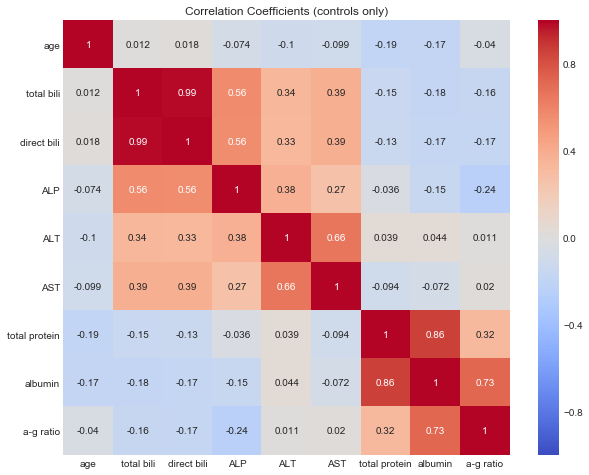

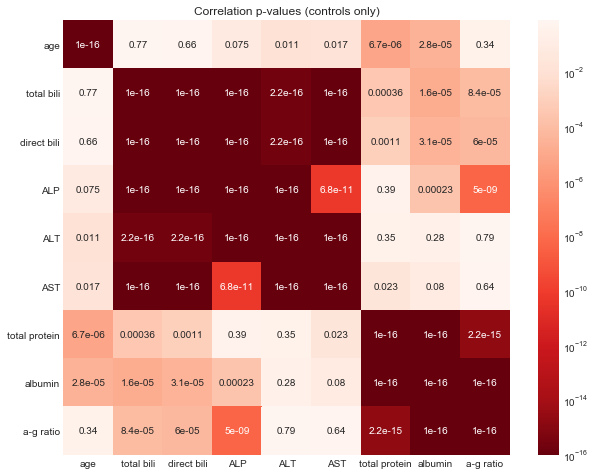

In [13]:
# correlation matrix for controls only
numeric_df_control = numeric_df[liver_df['liver disease'] == False]
corr_heatmaps(numeric_df_control, sub_str='controls only')

___
Surprisingly, the correlations among the two groups actually appear to be stronger within the controls. This may indicate that these measures are correlated due to normal physiological processes, rather than due to disease states.
___

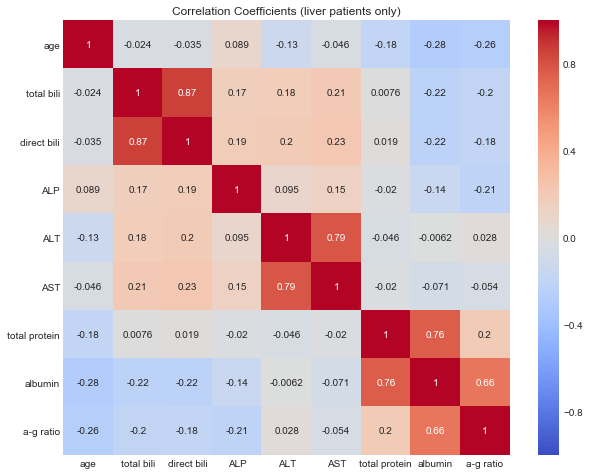

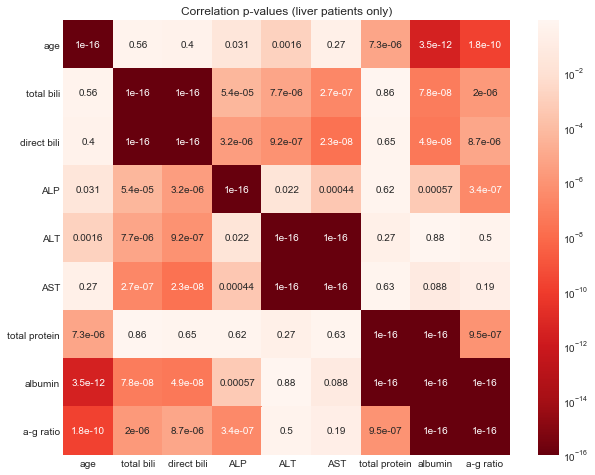

In [14]:
# correlation matrix for liver patients only
numeric_df_disease = numeric_df[liver_df['liver disease'] == True]
corr_heatmaps(numeric_df_disease, sub_str='liver patients only')

___
Notably, the correlation between ALP and the other two liver enzymes is weaker in liver patients than it is in controls. In contrast, the correlation between ALT and AST is stronger in liver patients than in controls.
___

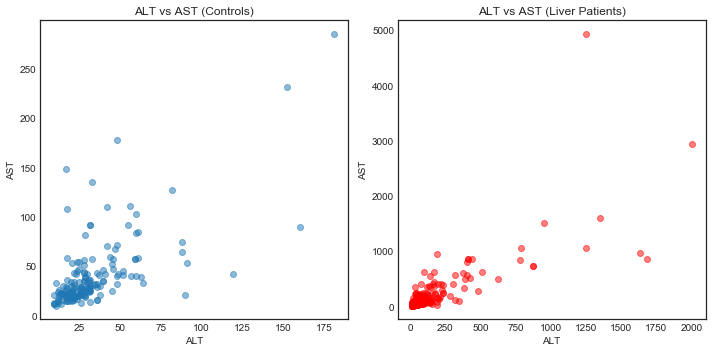

In [9]:
# visualize ALT vs AST in controls and liver patients
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(numeric_df_control['ALT'], numeric_df_control['AST'], alpha=0.5)
plt.title('ALT vs AST (Controls)')
plt.xlabel('ALT')
plt.ylabel('AST')

plt.subplot(1, 2, 2)
plt.scatter(numeric_df_disease['ALT'], numeric_df_disease['AST'], color='red', alpha=0.5)
plt.title('ALT vs AST (Liver Patients)')
plt.xlabel('ALT')
plt.ylabel('AST')
plt.tight_layout()
plt.show()

___
There does appear to be a strong relationship between ALT and AST in liver patients. This may indicate that ALT and AST have overlapping significance in the diagnosis of liver disease.
___

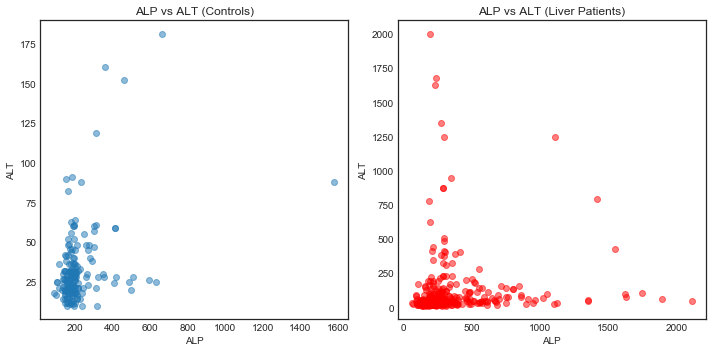

In [10]:
# visualize ALP vs ALT in controls and liver patients

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(numeric_df_control['ALP'], numeric_df_control['ALT'], alpha=0.5)
plt.title('ALP vs ALT (Controls)')
plt.xlabel('ALP')
plt.ylabel('ALT')

plt.subplot(1, 2, 2)
plt.scatter(numeric_df_disease['ALP'], numeric_df_disease['ALT'], color='red', alpha=0.5)
plt.title('ALP vs ALT (Liver Patients)')
plt.xlabel('ALP')
plt.ylabel('ALT')
plt.tight_layout()
plt.show()

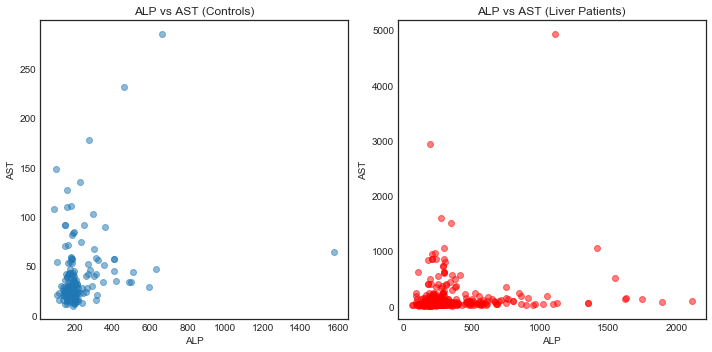

In [11]:
# visualize ALP vs AST in controls and liver patients

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(numeric_df_control['ALP'], numeric_df_control['AST'], alpha=0.5)
plt.title('ALP vs AST (Controls)')
plt.xlabel('ALP')
plt.ylabel('AST')

plt.subplot(1, 2, 2)
plt.scatter(numeric_df_disease['ALP'], numeric_df_disease['AST'], color='red', alpha=0.5)
plt.title('ALP vs AST (Liver Patients)')
plt.xlabel('ALP')
plt.ylabel('AST')
plt.tight_layout()
plt.show()

An interesting effect becomes apparent when plotting ALP vs ALT/AST in liver patients. Most liver patients that have hugely elevated ALP do not have a huge elevation of ALT or AST, and vice versa. This may be evidence that ALP and ALT/AST have unique significance in the diagnosis of liver disease. For example, ALP may be elevated in a different type of liver disease than ALT/AST. 

Because of these relationships, the inclusion of all three measures in the machine learning model should allow for better prediction than any of the measures alone.
___